In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os


In [ ]:
# Version check
import google.protobuf

print("TF:", tf.__version__)
print("TFDS:", tfds.__version__)
print("protobuf:", google.protobuf.__version__)


In [ ]:
# Dataset load with 80/20 split
(train_ds, val_ds), info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],  # 80% train, 20% validation
    with_info=True,
    as_supervised=True
)

num_classes = info.features["label"].num_classes
print("Number of classes:", num_classes)


In [ ]:
# Preprocessing
IMG_SIZE = 224
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# For validation
def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)  # EfficientNet preprocessing
    return image, label

# For training with augmentation
def augment_and_preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = data_augmentation(image)
    image = preprocess_input(image)
    return image, label

# Apply preprocessing, shuffle, batch, and augmentation
train_ds = train_ds.map(augment_and_preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Visualization of sample images
# Take one batch from the dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    
    for i in range(9):  # show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())  # convert Tensor to NumPy for plotting
        plt.title(int(labels[i].numpy()))  # show class index as title
        plt.axis("off")


In [ ]:
# Build Functional model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base model

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)   # EfficientNet feature extractor
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, save_weights_only=True)
]


In [ ]:
# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


In [ ]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:  # freeze all except last 50
    layer.trainable = False

# Re-compile with lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune training
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


In [ ]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")


In [ ]:
# Plot training curves
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# Get class names
class_names = info.features["label"].names

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i].numpy()]
        pred_label = class_names[pred_classes[i]]
        plt.title(f"T:{true_label}, P:{pred_label}")
        plt.axis("off")
    plt.show()
    break


In [54]:
# Load best model with just weights
# Rebuild the model in the same way
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

# Compile with same settings
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# load weights
model.load_weights("best_model.h5")


1/1 [==============================] - 1s 1s/step
Predicted class: sunflowers (confidence: 0.93)


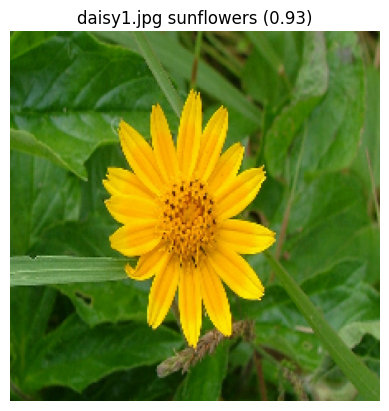

1/1 [==============================] - 0s 59ms/step
Predicted class: daisy (confidence: 1.00)


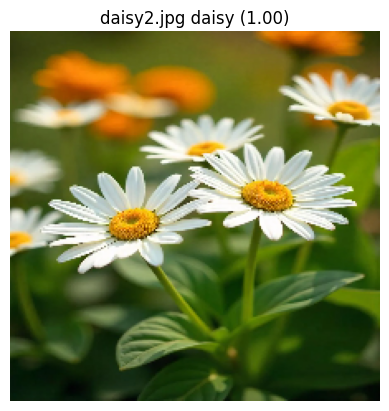

1/1 [==============================] - 0s 57ms/step
Predicted class: daisy (confidence: 0.68)


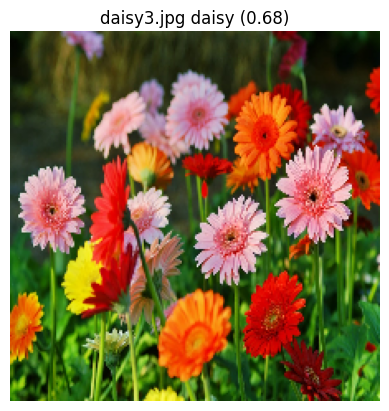

1/1 [==============================] - 0s 64ms/step
Predicted class: dandelion (confidence: 1.00)


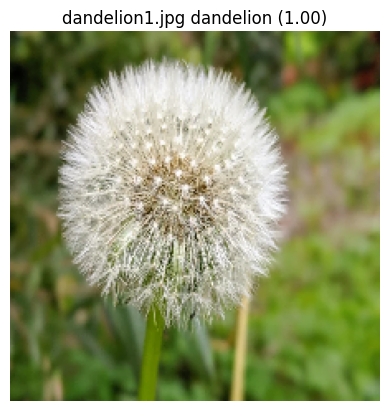

1/1 [==============================] - 0s 57ms/step
Predicted class: dandelion (confidence: 1.00)


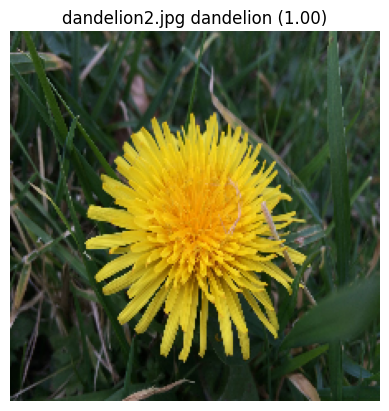

1/1 [==============================] - 0s 72ms/step
Predicted class: dandelion (confidence: 0.99)


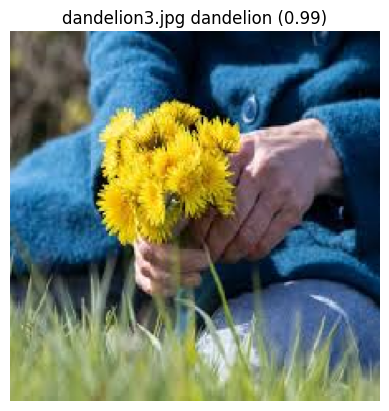

1/1 [==============================] - 0s 57ms/step
Predicted class: roses (confidence: 0.99)


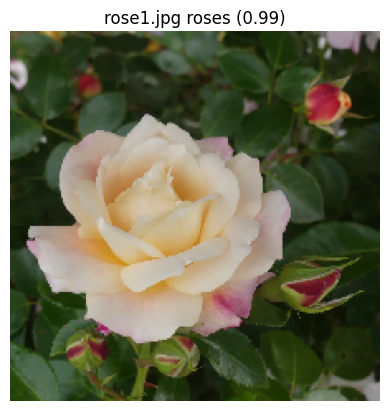

1/1 [==============================] - 0s 67ms/step
Predicted class: roses (confidence: 0.37)


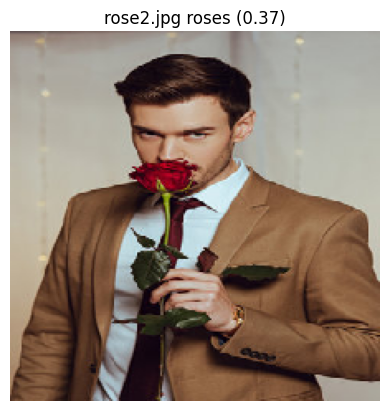

1/1 [==============================] - 0s 55ms/step
Predicted class: sunflowers (confidence: 1.00)


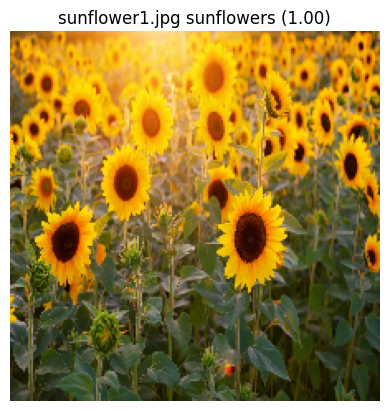

1/1 [==============================] - 0s 78ms/step
Predicted class: sunflowers (confidence: 0.96)


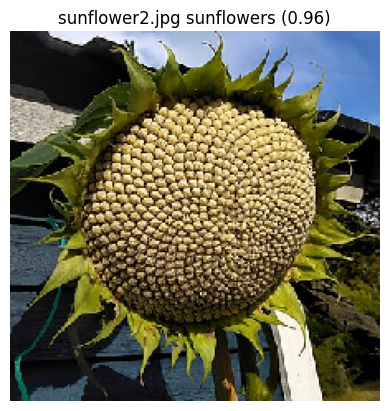

1/1 [==============================] - 0s 54ms/step
Predicted class: sunflowers (confidence: 1.00)


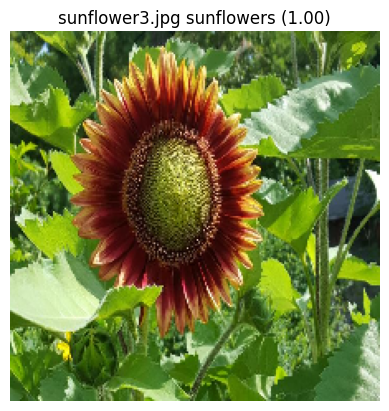

1/1 [==============================] - 0s 58ms/step
Predicted class: tulips (confidence: 0.99)


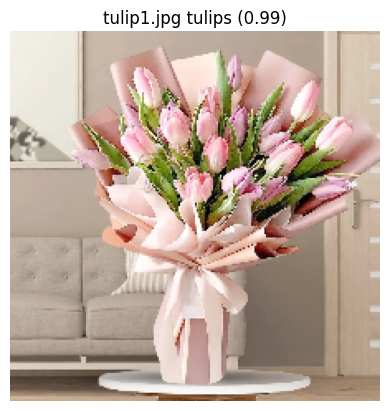

1/1 [==============================] - 0s 58ms/step
Predicted class: tulips (confidence: 1.00)


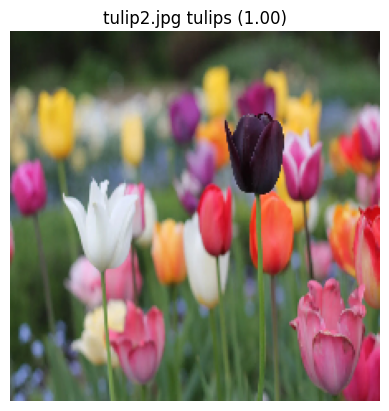

In [55]:
# predict custom images
def predict_custom_image(img_path, model, class_names):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    img_array = preprocess_input(img_array)

    # Run prediction
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    confidence = np.max(preds[0])

    print(f"Predicted class: {class_names[predicted_class]} (confidence: {confidence:.2f})")

    # Show the image
    plt.imshow(img)
    plt.title(f"{os.path.basename(img_path)} {class_names[predicted_class]} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

class_names = info.features["label"].names

folder_path = "my_flowers"

for filename in os.listdir(folder_path):
    if filename.lower().endswith(".jpg") or filename.lower().endswith(".jpeg") or filename.lower().endswith(".png"):
        img_path = os.path.join(folder_path, filename)
        predict_custom_image(img_path, model, class_names)
